In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button
from operator import itemgetter, attrgetter
from datetime import date
import json

In [16]:
# Constants

NOT_VISITED = -1
UNBLOCKED = 0
BLOCKED = 1
START = 2
END = 3
KNOWN_UNBLOCKED = 4
KNOWN_BLOCKED = 5
KNOWN_DEADEND = 6
KNOWN_VISITED = 7
KNOWN_OPENLIST = 8
PATH = 9

COLORMAP = {
    NOT_VISITED : np.array([127,127,127]),#grey
    UNBLOCKED : np.array([255,255,255]),#white
    BLOCKED : np.array([0,0,0]),#black
    START : np.array([255,0,0]),#red
    END : np.array([0,127,255]),#blue
    KNOWN_UNBLOCKED : np.array([248,131,121]),#pink
    KNOWN_BLOCKED : np.array([0,0,0]),#black
    KNOWN_DEADEND : np.array([255,0,255]),#purple
    KNOWN_VISITED : np.array([255,255,0]),#yellow
    KNOWN_OPENLIST : np.array([0,255,255]),#cyan
    PATH : np.array([0,255,127]),#green
}

TEST_RUNS = 5
TEST_WORLD_SIZE = 101

DEADEND = 426738462
SUCCESS = 798654362
TERMINATED = 253463839

OUTPUT_BASE_PATH = "Outputs/"
TODAY = date.today()

In [3]:
# Implementation of MinHeap to use it as
# priority queue in A*

class MinHeap:
    def __init__(self):
        self.elements = []
        self.size = 0

    def heapifyUpwards(self, i):
        while i != 0:
            p = (i - 1) // 2
            if self.elements[i][0] < self.elements[p][0]:
                self.elements[i], self.elements[p] = self.elements[p], self.elements[i]
            i = p

    def heapifyDownwards(self, i):
        while i < self.size:
            if 2 * (i + 1) >= self.size:
                m = (2 * i) + 1
            else:
                m = (2 * i) + 1 if self.elements[(2 * i) + 1][0] < self.elements[2 * (i + 1)][0] else 2 * (i + 1)
            if m>=self.size:
                break
            if self.elements[m][0] < self.elements[i][0]:
                self.elements[i], self.elements[m] = self.elements[m], self.elements[i]
            i = m

    def length(self):
        return self.size

    def insert(self, k):
        self.elements.append(k)
        self.size+=1
        self.heapifyUpwards(self.size-1)

    def peek(self):
        print(self.elements)
        return self.elements[0]

    def pop(self):
        k = self.elements[0]
        self.elements[0] = self.elements[-1]
        del self.elements[-1]
        self.size-=1
        self.heapifyDownwards(0)
        return k

# Custom class to use as the key for Priority queue,
# such that it takes two values, and a pair of weights
# to compare each other's priority.
# When weight is (0,1), the priorities are dependant
# only on g, which acts like DFS. When weights are
# (1,0), the priorities are decided purely on heuristics.
# And any other balance in-between can also be provided
class EvaluationPair:
    def __init__(self, h, g, weight):
        self.h=h
        self.g=g
        self.weight=weight
    def __eq__(self, other):
        return self.weight[0]*self.h + self.weight[1]*self.g == self.weight[0]*other.h + self.weight[1]*other.g
    def __ne__(self, other):
        return self.weight[0]*self.h + self.weight[1]*self.g != self.weight[0]*other.h + self.weight[1]*other.g
    def __gt__(self, other):
        return self.weight[0]*self.h + self.weight[1]*self.g > self.weight[0]*other.h + self.weight[1]*other.g
    def __ge__(self, other):
        return self.weight[0]*self.h + self.weight[1]*self.g >= self.weight[0]*other.h + self.weight[1]*other.g
    def __lt__(self, other):
        return self.weight[0]*self.h + self.weight[1]*self.g < self.weight[0]*other.h + self.weight[1]*other.g
    def __le__(self, other):
        return self.weight[0]*self.h + self.weight[1]*self.g <= self.weight[0]*other.h + self.weight[1]*other.g

In [4]:
def calculateAllNeighbours(location, t_size):
    # We first calculate all 9 cells in the neighbourhood,
    # and then filter out itself and the ones in the cross
    # by filtering elements with manhattan distance not equal to one.
    return list(filter(lambda x: abs(location[0]-x[0])+abs(location[1]-x[1])==1, [(x,y) for x in range(location[0]-1 if location[0]-1 > -1 else 0, location[0]+2 if location[0]+1<t_size else t_size) for y in range(location[1]-1 if location[1]-1 > -1 else 0, location[1]+2 if location[1]+1<t_size else t_size)]))

In [5]:
def getRandomCoordinates(t_size):
    # Returns a tuple of coordinnates
    return (random.randint(0, t_size - 1), random.randint(0, t_size-1))

def getRandomCoordinatesInQuarter(t, quarter):
    # Returns a tuple of coordinnates
    t_ = t - 1
    x = (0,int(t_/8)) if quarter[0] == 0 else (int(7*t_/8), t_)
    y = (0,int(t_/8)) if quarter[1] == 0 else (int(7*t_/8), t_)
    return (random.randint(x[0], x[1]), random.randint(y[0], y[1]))

In [6]:
def generateEnvironment(t):
    # Initially all cells are set as not visited
    # 1 marks blocked, 0 marks unblocked, -1 for not visited
    grid = np.full(shape = (t, t), fill_value = NOT_VISITED, dtype = np.int8)

    # A random location on the grid to begin with, and mark it visited
    begin = getRandomCoordinates(t)
    grid[begin[0], begin[1]] = BLOCKED

    # Using a stack as a frontier, so we can use DFS to generate the blocked paths
    frontier = []
    frontier.append(begin)
    while(len(frontier) > 0):
        current = frontier.pop()
        # Calculating the current's neighbours
        neighbours = calculateAllNeighbours(current, t)
        for nx,ny in neighbours:
            if grid[nx,ny] == NOT_VISITED:
                # If the location is not visited, add it to the frontier
                frontier.append((nx,ny))
                # Mark it blocked or unblocked randomly
                grid[nx,ny] = BLOCKED if random.random() > 0.7 else UNBLOCKED
    start = getRandomCoordinatesInQuarter(t, (0,0))
    reach = getRandomCoordinatesInQuarter(t, (1,1))
    grid[start] = START
    grid[reach] = END
    return grid, start, reach

In [7]:
def showGrid(grid, name):
    # Fancypants util that makes use of predefined colours
    # for each data value in the grid and makes it easier to visualise
    plt.clf()
    if grid.shape[0]<30:
        plt.xticks(np.arange(0, grid.shape[0]))
        plt.yticks(np.arange(0, grid.shape[0]))
    else:
        plt.xticks(np.arange(0, grid.shape[0], 10))
        plt.yticks(np.arange(0, grid.shape[0], 10))
    plt.imshow(X = [[COLORMAP[e] for e in row] for row in grid])
    plt.savefig(OUTPUT_BASE_PATH + TODAY.strftime("%d-%m-%Y") + "-" + name + ".png", bbox_inches="tight", format="png")

In [8]:
def initAgentKnowlegde(grid, start, reach):
    agentKnowledge = np.full(shape = grid.shape, fill_value = NOT_VISITED, dtype = np.int8)
    agentKnowledge[start] = START
    agentKnowledge[reach] = END
    return agentKnowledge

In [9]:
def manhattanDistance(pos1, pos2):
    # pos1 and pos2 are coordinates
    return abs(pos2[1] - pos1[1]) + abs(pos2[0] - pos1[0])

In [10]:
def tracePath(agentKnowledge, parentMatrix, current, start):
    path = []
    while parentMatrix[current[0]][current[1]] != (-1,-1):
        agentKnowledge[current] = PATH
        path.append(current)
        current = parentMatrix[current[0]][current[1]]
    return [start] + list(reversed(path))

def AStar_(environment, start, reach, t, stopAtDeadend, tiebreakWeight, isAdaptive, hueristicAdaptive=None):
    agentKnowledge = initAgentKnowlegde(environment, start, reach)
    gcost = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    hueristic  = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    parentMatrix = [[(-1,-1) for _ in range(environment.shape[0])] for _ in range(environment.shape[1])]
    openList = MinHeap()
    closedList = []
    gcost[start] = 0
    if not isAdaptive:
        hueristic[start] = manhattanDistance(start,reach)
    else:
        hueristic = hueristicAdaptive
    hueristic[start] = manhattanDistance(start,reach)
    openList.insert((EvaluationPair(hueristic[start], gcost[start], tiebreakWeight), start, (-1,-1)))
    while openList.length() > 0:
        cellData = openList.pop()
        current = cellData[1]
        parent = cellData[2]
        closedList.append(current)
        parentMatrix[current[0]][current[1]] = parent
        agentKnowledge[current] = KNOWN_VISITED
        if current == reach:
            path = tracePath(agentKnowledge, parentMatrix, current, start)
            agentKnowledge[start] = START
            agentKnowledge[current] = END
            return {
                "success":True,
                "status":"Success",
                "statusCode":SUCCESS,
                "current":current,
                "closedList":closedList,
                "hueristic":hueristic,
                "gcost": gcost,
                "path":path,
                "agentKnowledge":agentKnowledge
            }
        neighbours = calculateAllNeighbours(current, t)
        validNeighbours = list(filter(lambda x: (environment[x] == UNBLOCKED or environment[x] == END or environment[x] == START) and x not in closedList, neighbours))
        blockedNeighbours = list(filter(lambda x: environment[x] == BLOCKED, neighbours))
        for i in blockedNeighbours:
            agentKnowledge[i] = KNOWN_BLOCKED
        if (current == start and len(blockedNeighbours) == len(neighbours)) or (current != start and len(blockedNeighbours) == len(neighbours)-1):
            agentKnowledge[current] = KNOWN_DEADEND
            if stopAtDeadend:
                path = tracePath(agentKnowledge, parentMatrix, current, start)
                agentKnowledge[start] = START
                agentKnowledge[current] = KNOWN_DEADEND
                agentKnowledge[reach] = END
                return {
                    "success":False,
                    "status":"Deadend",
                    "statusCode":DEADEND,
                    "current":current,
                    "closedList":closedList,
                    "hueristic":hueristic,
                    "gcost": gcost,
                    "path":path,
                    "agentKnowledge":agentKnowledge
                }
        else:
            for i in validNeighbours:
                gcost[i] = gcost[current] + 1
                if not isAdaptive:
                    hueristic[i] = manhattanDistance(i,reach)           
                elif (isAdaptive and hueristicAdaptive[i] == 0):
                    hueristic[i] = manhattanDistance(i,reach)
                openList.insert((EvaluationPair(hueristic[i],gcost[i], tiebreakWeight), i, current))
    path = tracePath(agentKnowledge, parentMatrix, current, start)
    agentKnowledge[start] = START
    agentKnowledge[reach] = END
    return {
        "success":False,
        "status":"No path possible",
        "statusCode":TERMINATED,
        "current":current,
        "closedList":closedList,
        "hueristic":hueristic,
        "gcost": gcost,
        "path":path,
        "agentKnowledge":agentKnowledge
    }

In [11]:
# Trace back on the current path, and find neighbours
# which are not visited, and are not already known to be deadend
def findWorkableNeighbour(deadend, visited, totalPath):
    flattendPath = sum([path for _,path in totalPath], [])
    i=0
    while i<len(flattendPath):
        current = flattendPath[-1-i]
        neighbours = calculateAllNeighbours(current, TEST_WORLD_SIZE)
        blockedNeighbours = list(filter(lambda x: environment[x]==BLOCKED, neighbours))
        unblockedNeighbours = list(set(neighbours)-set(blockedNeighbours))
        for j in unblockedNeighbours:
            if j not in visited and j!=deadend:
                return j
        current = flattendPath[-1-i]
        i+=1
    return (-1,-1)

def repFwdAStar_(environment, start, reach, t, tiebreakWeight):
    totalPath = []
    nodesExplored = 0
    current = start
    ans = AStar_(environment, current, reach, t, True, tiebreakWeight, False)
    path = ans["path"]
    totalPath.append((current, path))
    nodesExplored += len(ans["closedList"])
    visited = set()
    visited.update([current])
    # Call A* until a deadend is encountered
    # Trace back and find a cell which is yet to be explored,
    # Start A* from there
    while ans["statusCode"] == DEADEND and len(path)>0:
        current = findWorkableNeighbour(ans["current"], visited, totalPath)
        if current == (-1,-1):
            break
        ans = AStar_(environment, current, reach, t, True, tiebreakWeight, False)
        path = ans["path"]
        totalPath.append((current, path))
        nodesExplored += len(ans["closedList"])
        visited.update([current])
    return {
        "ans":ans,
        "totalPath":totalPath,
        "nodesExplored":nodesExplored
    }

def repBckAStar_(environment, start, reach, t, tiebreakWeight):
    return repFwdAStar_(environment, reach, start, t, tiebreakWeight)

In [12]:
"""
def AdaptiveAStar(environment,start,reach):
    totalPath = []
    current = start
    ans = AStar_(environment, current, reach, t=TEST_WORLD_SIZE, stopAtDeadend = False, tiebreakWeight=(1,1), isAdaptive = False)
    path = ans["path"]
    totalPath.append((current, path))
    step = 0
    Ntrials = 20
    visited = set()
    visited.update([current])
    hueristicAdaptive = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    #IterativeHueristic = ans["hueristic"]
    #print(IterativeHueristic)
    #print((totalPath))
    #IterativeGcost = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    
    #print("First Run", ans["hueristic"])
    
    #print("after step {}:{}".format(step, totalPath))
    #for i in range(Ntrials) :
    #print(hueristicAdaptive)
    count = 0
    IterativeGcost = ans["gcost"]
    #print(IterativeGcost)
    for k in range(Ntrials):
        for i,j in ans["closedList"]:
            hueristicAdaptive[i,j] = (IterativeGcost[reach] - IterativeGcost[i,j])
        adaptiveAstar = AStar_(environment, current, reach , t=TEST_WORLD_SIZE, stopAtDeadend = False, tiebreakWeight=(1,1), isAdaptive = True, hueristicAdaptive= hueristicAdaptive)
        IterativeGcost = adaptiveAstar["gcost"] 
        print("After step ",format(k),len(adaptiveAstar["closedList"]))
    
    print("test A* run", len(ans["closedList"]))
    print()
"""

'\ndef AdaptiveAStar(environment,start,reach):\n    totalPath = []\n    current = start\n    ans = AStar_(environment, current, reach, t=TEST_WORLD_SIZE, stopAtDeadend = False, tiebreakWeight=(1,1), isAdaptive = False)\n    path = ans["path"]\n    totalPath.append((current, path))\n    step = 0\n    Ntrials = 20\n    visited = set()\n    visited.update([current])\n    hueristicAdaptive = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)\n    #IterativeHueristic = ans["hueristic"]\n    #print(IterativeHueristic)\n    #print((totalPath))\n    #IterativeGcost = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)\n    \n    #print("First Run", ans["hueristic"])\n    \n    #print("after step {}:{}".format(step, totalPath))\n    #for i in range(Ntrials) :\n    #print(hueristicAdaptive)\n    count = 0\n    IterativeGcost = ans["gcost"]\n    #print(IterativeGcost)\n    for k in range(Ntrials):\n        for i,j in ans["closedList"]:\n            hueristicAdap

In [13]:
def AdaptiveAStar(environment,start,reach):
    totalPath = []
    nodesExplored = 0
    current = start
    ans = AStar_(environment, current, reach, TEST_WORLD_SIZE, False, tiebreakWeight=(1,1), isAdaptive=False, hueristicAdaptive = "")
    path = ans["path"]
    totalPath.append((current, path))
    nodesExplored += len(ans["closedList"])
    visited = set()
    visited.update([current])
    hueristicAdaptive = np.full(shape = environment.shape, fill_value = 0, dtype = np.int64)
    IterativeGcost = ans["gcost"]
    # Call A* until a deadend is encountered
    # Trace back and find a cell which is yet to be explored,
    # Start A* from there
    
    while ((ans["statusCode"] == DEADEND and len(path)>0) or (current == start)):
        current = findWorkableNeighbour(ans["current"], visited, totalPath)
        
        if current == (-1,-1):
            break
        for i,j in ans["closedList"]:
            hueristicAdaptive[i,j] = (IterativeGcost[reach] - IterativeGcost[i,j]) 
        ans = AStar_(environment, current, reach, TEST_WORLD_SIZE, True, tiebreakWeight = (1,1), isAdaptive = True, hueristicAdaptive = hueristicAdaptive)
        IterativeGcost = ans["gcost"] 
        path = ans["path"]
        totalPath.append((current, path))
        nodesExplored += len(ans["closedList"])
        visited.update([current])
    return {
        "ans":ans,
        "totalPath":totalPath,
        "nodesExplored":nodesExplored
    }

In [19]:
AdaptiveAStar(environment, start, reach)

{'ans': {'success': True,
  'status': 'Success',
  'statusCode': 798654362,
  'current': (93, 89),
  'closedList': [(94, 89), (93, 89)],
  'hueristic': array([[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0, 179, 180, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]]),
  'gcost': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'path': [(94, 89), (93, 89)],
  'agentKnowledge': array([[-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         ...,
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)},
 'totalPat

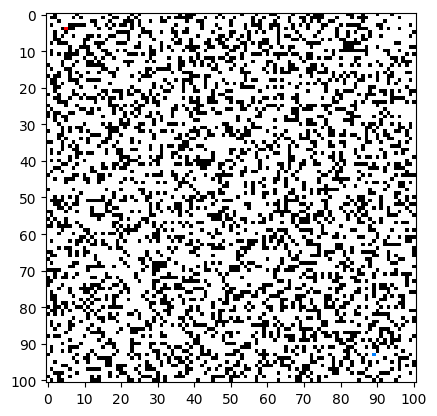

In [18]:
environment, start, reach = generateEnvironment(TEST_WORLD_SIZE)
showGrid(environment, "base_environment")

In [20]:
%%time
ans = AStar_(environment, start, reach, t=TEST_WORLD_SIZE, stopAtDeadend=False, tiebreakWeight=(1,1), isAdaptive = False)

CPU times: user 88.3 ms, sys: 0 ns, total: 88.3 ms
Wall time: 87.6 ms


True
1480


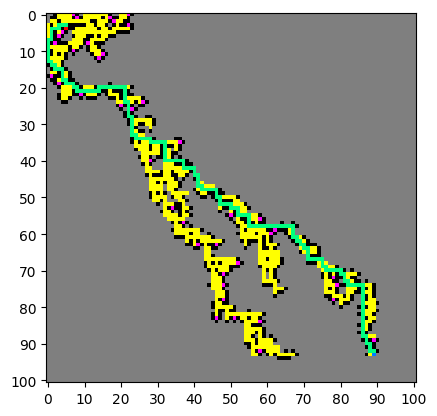

In [21]:
print(ans["success"])
print(len(ans["closedList"]))
showGrid(ans["agentKnowledge"], "final_state")

In [22]:
%%time
repFwdAns = repFwdAStar_(environment, start, reach, t=TEST_WORLD_SIZE, tiebreakWeight=(1,1))

CPU times: user 235 ms, sys: 0 ns, total: 235 ms
Wall time: 234 ms


In [23]:
repFwdPath = repFwdAns["totalPath"]

print(repFwdAns["ans"]["status"])
print(repFwdAns["nodesExplored"])

Success
4685


In [24]:
%%time
repBckAns = repBckAStar_(environment, start, reach, t=TEST_WORLD_SIZE, tiebreakWeight=(1,1))

CPU times: user 364 ms, sys: 877 µs, total: 364 ms
Wall time: 364 ms


In [25]:
repBckPath = repBckAns["totalPath"]

print(repBckAns["ans"]["status"])
print(repBckAns["nodesExplored"])

Success
9262


In [ ]:
# %matplotlib widget

# #https://stackoverflow.com/questions/55401246/pyplot-imshow-3d-array-with-a-slider

# agentVisual = ans[2]

# idx0 = 0
# plt.clf()
# plt.xticks([])
# plt.yticks([])
# l = plt.imshow(X = [[COLORMAP[e] for e in row] for row in agentVisual[idx0]])

# axidx = plt.axes([0.1, 0.25, 0.0225, 0.63])
# slidx = Slider(axidx, 'Step Number', 0, len(agentVisual)-1, valinit=idx0, valfmt='%d', orientation='vertical')

# def update(val):
#     idx = slidx.val
#     l.set_data([[COLORMAP[e] for e in row] for row in agentVisual[int(idx)]])
# slidx.on_changed(update)

# plt.show()

In [ ]:
# with open(OUTPUT_BASE_PATH+"environment_1", 'w') as f:
#     json.dump((environment.tolist(), start, reach) , f)

# with open(OUTPUT_BASE_PATH+"environment", 'r') as f:
#     env, start_, reach_ = json.load(f)
# environment = np.array(env)
# start = (start_[0], start_[1])
# reach = (reach_[0], reach_[1])